# Convolutional Neural Network On The CIFAR-10 Dataset



Files already downloaded and verified
Files already downloaded and verified
Epoch [1/10], Step [2000/10000], Loss: 2.1271
Epoch [1/10], Step [4000/10000], Loss: 1.3800
Epoch [1/10], Step [6000/10000], Loss: 0.9961
Epoch [1/10], Step [8000/10000], Loss: 1.9460
Epoch [1/10], Step [10000/10000], Loss: 1.5558
Finished Training
Accuracy of the network: 53.45 %
Accuracy of plane: 56.9 %
Accuracy of car: 68.1 %
Accuracy of bird: 21.7 %
Accuracy of cat: 17.0 %
Accuracy of deer: 36.3 %
Accuracy of dog: 52.8 %
Accuracy of frog: 72.5 %
Accuracy of horse: 69.5 %
Accuracy of ship: 69.7 %
Accuracy of truck: 70.0 %
Epoch [2/10], Step [2000/10000], Loss: 1.4132
Epoch [2/10], Step [4000/10000], Loss: 0.3781
Epoch [2/10], Step [6000/10000], Loss: 1.3078
Epoch [2/10], Step [8000/10000], Loss: 0.6064
Epoch [2/10], Step [10000/10000], Loss: 1.3303
Finished Training
Accuracy of the network: 65.08 %
Accuracy of plane: 81.7 %
Accuracy of car: 88.3 %
Accuracy of bird: 50.0 %
Accuracy of cat: 29.6 %
Accuracy of

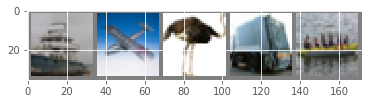

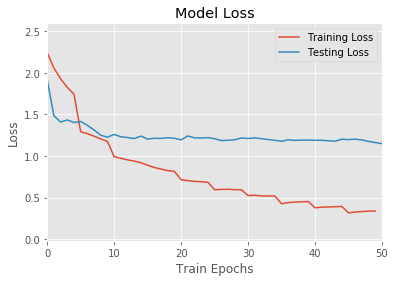

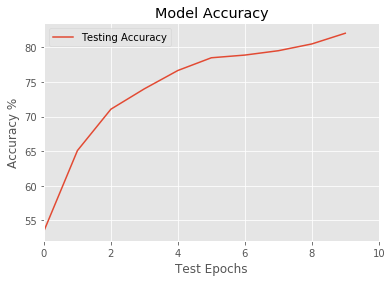

In [144]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms 
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np 

#choosing the available device 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#defining the model's hyper-parameters 
num_epochs = 10
batch_size = 5
learning_rate = 0.001

#tranformation of images to tensors of normalised range [-1,1]
transform = transforms.Compose(
            [transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#downloading and loading the training dataset and the testing dataset (CIFAR-10)
train_dataset = CIFAR10(root='CIFAR10/', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='CIFAR10/', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

#the Convolution Neural Network
class ConvNN(nn.Module):
    def __init__(self):
        super(ConvNN, self).__init__()
        self.loss_history = []
        self.test_loss = []
        self.trn_acc_history = []
        self.acc_history = []
        self.conv_layer = nn.Sequential(
            
            # Conv Layer 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Conv Layer 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),
            
            # Conv Layer 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        #Fully connected layer
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )
        # forward porpogation method
    def forward(self,x):
        # conv layers
        x = self.conv_layer(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # fully connected layer
        x = self.fc_layer(x)

        return x
        
#generating model object           
model = ConvNN().to(device)

#defining the cross entropy loss and the model optimiser
criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(model.parameters(), lr=learning_rate)

n_total_steps = len(train_loader)

#training of the model
for epoch in range(num_epochs):
    epoch_loss=[]
    for i, (images, labels) in enumerate(train_loader):
        model.train()
        
        images = images.to(device)
        labels = labels.to(device)
        
        
        #forward prop
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        #backward prop and optimise 
        optimiser.zero_grad()
        epoch_loss.append(loss.item())
        loss.backward()
        optimiser.step()
        
        if (i+1) % 2000 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

            model.loss_history.append(sum(epoch_loss)/len(epoch_loss))
           
    print('Finished Training')
    
#testing of the model    
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        n_class_correct = [0 for i in range(10)]
        n_class_samples = [0 for i in range(10)]
        v_loss = []
        model.eval()
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            v_loss.append(loss.item())
           
            total = labels.size(0)
            _, predicted = torch.max(outputs, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            
            model.test_loss.append(sum(v_loss)/len(v_loss))
            
            for i in range(batch_size):
                label = labels[i]
                pred = predicted[i]
                if (label == pred):
                    n_class_correct[label] += 1
                n_class_samples[label] += 1
        
        acc = 100.0 * n_correct/n_samples
        running_acc = acc/n_total_steps
        model.acc_history.append(acc)
        print(f'Accuracy of the network: {acc} %')
        
      
        for i in range(10):
            acc = 100.0 * n_class_correct[i] / n_class_samples[i]
            print(f'Accuracy of {classes[i]}: {acc} %')
            
#saving the trained model
PATH = "checkpoint/chkpt.pth"
torch.save(model.state_dict(), PATH)

#loading random images from the training dataset
def imshow(img):
    img = img / 2 + 0.5 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images from the dataset
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show the images
imshow(torchvision.utils.make_grid(images))

#plotting the Model loss graph showing the loss in training and testing        
plt.plot(model.loss_history, label='Training Loss')
plt.plot(model.test_loss, label='Testing Loss')
plt.style.use('ggplot')
plt.title('Model Loss')    
plt.xlabel('Train Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xlim([0, 50])
plt.show()

#plotting the model accuracy shoing the overall accuracy of the model
plt.plot(model.acc_history, label='Testing Accuracy')
plt.style.use('ggplot')
plt.title('Model Accuracy')    
plt.xlabel('Test Epochs')
plt.ylabel('Accuracy %')
plt.legend()
plt.xlim([0, 10])
plt.show()

# Generating Adversarial Examples using the Fast-Gradient Sign Method & Testing the model's Robustness

In [145]:
import os
import sys
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import torchvision.utils
import torchvision.models as models

import torchvision.datasets as dsets
import torchvision.transforms as transforms

import torchattacks
from torchattacks import FGSM
import matplotlib.pyplot as plt
%matplotlib inline


#generating FGSM attack and applying it to the test dataset
fgsm_attack = torchattacks.FGSM(model, eps=0.007)
fgsm_attack.set_return_type('int') 
fgsm_attack.save(data_loader=test_loader, save_path="./data/cifar10_fgsm.pt", verbose=True)

#generating an adversarial dataset from the test dataset
adv_images, adv_labels = torch.load("./data/cifar10_fgsm.pt")
adv_data = TensorDataset(adv_images.float()/255, adv_labels)
adv_loader = DataLoader(adv_data, batch_size=128, shuffle=False)

#calling on the saved model
model = ConvNN().to(device)
model.load_state_dict(torch.load(PATH))

#setting model to testing mode
model.eval()

correct = 0
total = 0

#calculating the accuracy of the model when not under FGSM attack 
for images, labels in test_loader:
    
    images = images.cuda()
    outputs = model(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()
    accuracy = 100 * float(correct)/total
    #acc.append(accuracy)
print('Standard accuracy: %.2f %%' % (100 * float(correct) / total))

correct = 0
total = 0

#generating accuracy of the model when under FGSM attack 
for images, labels in adv_loader:
    
    images = images.cuda()
    outputs = model(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()
    robustness = 100 * float(correct)/total
    robust.append(robustness)
print('Robust accuracy: %.2f %%' % (100 * float(correct) / total))



- Save Progress : 100.00 % / Accuracy : 41.88 %
- Save Complete!
Standard accuracy: 82.06 %
Robust accuracy: 41.88 %
